<a href="https://colab.research.google.com/github/Barikko/Yandex.Practicum-Projects/blob/main/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB_%D0%90%D0%91_%D1%82%D0%B5%D1%81%D1%82%D1%8B_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект по А/B-тестированию

## Описание проекта

### Постановка задачи

Задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

    Оценить корректность проведения теста.
    Проанализировать результаты теста.

Чтобы оценить корректность проведения теста, необходимо проверить:

    пересечение тестовой аудитории с конкурирующим тестом;
    совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

    Название теста: recommender_system_test;
    Группы: А (контрольная), B (новая платёжная воронка);
    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Аудитория: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемое количество участников теста: 6000.
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
      
        конверсии в просмотр карточек товаров — событие product_page
        просмотры корзины — product_cart
        покупки — purchase.

### Данные

ab_project_marketing_events.csv
final_ab_new_users.csv
final_ab_events.csv
final_ab_participants.csv

    ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
    Структура файла:
      
        name — название маркетингового события;
        regions — регионы, в которых будет проводиться рекламная кампания;
        start_dt — дата начала кампании;
        finish_dt — дата завершения кампании.

    final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
    Структура файла:
        user_id — идентификатор пользователя;
        first_date — дата регистрации;
        region — регион пользователя;
        device — устройство, с которого происходила регистрация.

    final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
    Структура файла:
        user_id — идентификатор пользователя;
        event_dt — дата и время события;
        event_name — тип события;
        details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

    final_ab_participants.csv — таблица участников тестов.
    Структура файла:
        user_id — идентификатор пользователя;
        ab_test — название теста;
        group — группа пользователя.

### Задачи:

    Цели исследования.
    Исследуйте данные:
      
        Требуется ли преобразование типов?
        Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?
    Оценка корректность проведения теста:
      
        Соответствие данных требованиям технического задания. Проверка корректности всех пунктов технического задания.
        Время проведения теста. Оно не должно совпадать с маркетинговыми и другими активностями.
        Аудитория теста. Она не должна пересекаться с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверка равномерность распределения пользователей по тестовым группам и правильность их формирования.
    Проведите исследовательский анализ данных:
      
        Количество событий на пользователя одинаково распределены в выборках?
        Как число событий в выборках распределено по дням?
        Как меняется конверсия в воронке в выборках на разных этапах?
        Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
    Оценка результатов A/B-тестирования:
      
        Что можно сказать про результаты A/B-тестирования?
        Проерка статистической разницы долей z-критерием
    Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Общее заключение о корректности проведения теста.

## Загрузка данных

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
from PIL import Image

In [35]:
calendar = pd.read_csv('/content/ab_project_marketing_events.csv')
events = pd.read_csv('/content/final_ab_events.csv')
new_users = pd.read_csv('/content/final_ab_new_users.csv')
participants = pd.read_csv('/content/final_ab_participants.csv')

In [36]:
display(calendar.head(5))
display(events.head(5))
display(new_users.head(5))
display(participants.head(5))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [37]:
print(calendar.info())
print(calendar.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
0


Приведём ниже время в нужный формат, пропусков и дубликатов нет.

In [38]:
print(events.info())
print(events.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
0


Приведём время в нужный формат, много пропусков в колонке details, потому что там содержится дополнительная информация, относящаяся не ко всем событиям. Дубликатов нет.

In [39]:
print(new_users.info())
print(new_users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
0


Приведём ниже время в нужный формат, пропусков и дубликатов нет.

In [40]:
print(participants.info())
print(participants.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
0


Пропусков и дубликатов нет.

In [41]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d')
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'], format='%Y-%m-%d')
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'], format='%Y-%m-%d')

In [42]:
print(participants['ab_test'].unique())
print(new_users['region'].unique())
print(new_users['device'].unique())

['recommender_system_test' 'interface_eu_test']
['EU' 'N.America' 'APAC' 'CIS']
['PC' 'Android' 'iPhone' 'Mac']


Всего два конкурирующих теста: анализируемый recommender_system_test и конкурент interface_eu_test. Пользователи регистрировались из таких регионов, как Европа, Северная Америка, Азиатско-Тихоокеанский регион и СНГ, используя ПК, телефон на Андроиде, Айфон и Мак.

## Оценка корректности проведения теста

### Проверка корректность всех пунктов технического задания

In [43]:
df = participants.merge(new_users, on='user_id')
df = df.merge(events, on='user_id', how='left')
recommender_system_test = df.query('ab_test == "recommender_system_test"')
interface_eu_test = df.query('ab_test == "interface_eu_test"')
start=recommender_system_test['first_date'].min()
end=recommender_system_test['first_date'].max()
print("Время запуска теста:" ,start)
print("Время остановки набора новых пользователей:", end)
print('Время остановки теста',recommender_system_test['event_dt'].max())
print("Аудитория теста:",recommender_system_test.query('region=="EU"')['user_id'].nunique(),)
print('Аудитория теста в % относительно всех EU пользователей: {:.1f}%'.format(recommender_system_test.query\
      ('region=="EU"')['user_id'].nunique()/new_users.query('region=="EU" & first_date<"2020-12-22"')['user_id'].count()*100))

Время запуска теста: 2020-12-07 00:00:00
Время остановки набора новых пользователей: 2020-12-21 00:00:00
Время остановки теста 2020-12-30 12:42:57
Аудитория теста: 6351
Аудитория теста в % относительно всех EU пользователей: 15.0%


Выводы:
   
   1. Время проведения теста - с 07.12.2020 по 30.12.2020, а не по 04.01.2021, как заявлено;
   3. Время остановки набора новых пользователей - c 07.12.2020 по 21.12.2020, с ТЗ совпадает;
   3. Аудитория теста - 6351, на 5% больше заявленной;
   4. Аудитория: 15% новых пользователей из региона EU, как и заявлено

### Время проведения теста

In [44]:
calendar.query('start_dt>=@start & finish_dt>=@end')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Время проведения теста совпадает с двумя событиями: Лотерея в регионе CIS, что не влияет на тест, и Рождественские праздники, что касается Европы, пересекается с тестом и может повлиять на результаты.

### Есть ли пересечение тестовой аудитории с конкурирующим тестом

In [45]:
print("Время запуска теста:" ,start)
print("Время остановки теста:", end)
print("Время начала теста interface_eu_test:", interface_eu_test['first_date'].min())
print("Время окончания теста interface_eu_test:", interface_eu_test['first_date'].max())

Время запуска теста: 2020-12-07 00:00:00
Время остановки теста: 2020-12-21 00:00:00
Время начала теста interface_eu_test: 2020-12-07 00:00:00
Время окончания теста interface_eu_test: 2020-12-23 00:00:00


In [46]:
total=df.groupby('user_id').nunique()
both = 0
for x in total['ab_test']:
    if x > 1:
        both += 1
print('Пользователей, участвующих одновременно в двух тестах:',both)
print('Уникальных пользователей в обоих тестах:', len(total))
print('% пользователей, участвующих одновременно в двух тестах к общему кол-ву участников: {:.1f}%'\
      .format(both/len(total)*100))

Пользователей, участвующих одновременно в двух тестах: 1602
Уникальных пользователей в обоих тестах: 16666
% пользователей, участвующих одновременно в двух тестах к общему кол-ву участников: 9.6%


Оба теста проводились в одно время, почти 10% пользователей участвовали в обоих тестах, пересечение есть. Избавимся от пользователей из обоих тестов.

In [47]:
x=total.query('ab_test>1')
df=df.query('user_id not in @x.index')
len(df)

97150

In [48]:
recommender_system_test=recommender_system_test.query('user_id not in @x.index')
recommender_system_test=recommender_system_test.query('region=="EU"')
len(recommender_system_test)

19681

 ### Равномерность распределения пользователей

In [49]:
total1 = recommender_system_test.groupby('user_id').nunique() 
both1 = 0
for x in total1['group']:
    if x > 1:
        both1 += 1
print('Количество участников, участвующих одновременно в двух группах:',both1)
print('Уникальных участников:', len(total1))
print('% участников, участвующих одновременно в двух тестах к общему количеству участников теста \
recommender_system_test: {:.1f}%'.format(both/len(total1)*100))
print(recommender_system_test.groupby('group')['user_id'].nunique())

Количество участников, участвующих одновременно в двух группах: 0
Уникальных участников: 4749
% участников, участвующих одновременно в двух тестах к общему количеству участников теста recommender_system_test: 33.7%
group
A    2713
B    2036
Name: user_id, dtype: int64


Пересечения по группам нет, в группе А 2713 участников, в группе В - 2036, распределение неравномерно, 34% пользователей участвуют одновременно в двух тестах.

In [50]:
#добавим колонку отдельно со днём события и с разницей между событиями, чтобы исключить события старше 14 дней
recommender_system_test['day'] = recommender_system_test['event_dt'].astype('datetime64[D]')
recommender_system_test['diff']=recommender_system_test['day']-recommender_system_test['first_date']
recommender_system_test['diff'] = recommender_system_test['diff'].apply(lambda x: x.days)
recommender_system_test=recommender_system_test.query('diff<15')

## Исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

In [51]:
x=recommender_system_test.query('group=="A"')['event_name'].count()
y=recommender_system_test.query('group=="A"')['user_id'].nunique()
print(x/y)

x=recommender_system_test.query('group=="B"')['event_name'].count()
y=recommender_system_test.query('group=="B"')['user_id'].nunique()
print(x/y)

6.956678700361011
5.4931297709923665


Нет, на пользователей группы А приходится на 1.5 действия больше.

### Как число событий в выборках распределено по дням?

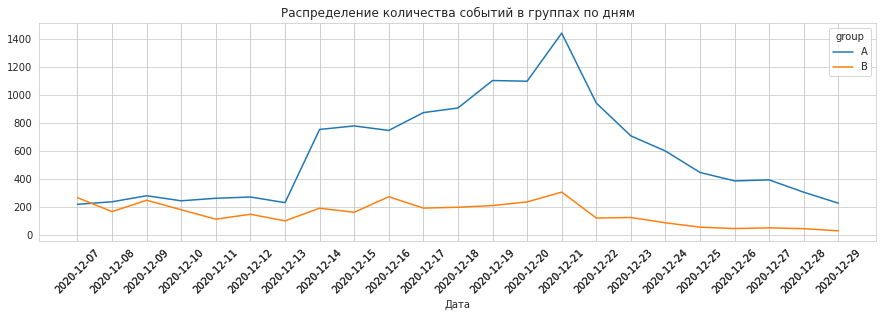

In [52]:
event_by_date = recommender_system_test.groupby(['day', 'group'])['user_id'].count().reset_index()
plt.figure(figsize=(15, 4))
sns.set_style("whitegrid")
ax = sns.lineplot(data=event_by_date, x='day', y='user_id', hue='group')
ax.set_xticks(event_by_date['day'])
ax.set_title('Распределение количества событий в группах по дням')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('');

In [53]:
recommender_system_test.query('day=="2020-12-14"').pivot_table(index='event_name',values='user_id',aggfunc='count')

,user_id
event_name,
login,434
product_cart,135
product_page,260
purchase,119


In [54]:
recommender_system_test.query('day=="2020-12-21"').pivot_table(index='event_name',values='user_id',aggfunc='count')

,user_id
event_name,
login,778
product_cart,218
product_page,499
purchase,255


В обеих группах наблюдается малое количество действий до 14 декабря, в котором у группы А происходит всплеск, такой же всплеск происходит и 21 декабря, потом количество действий падает. Всплески связаны с регистрацией огромного количества пользователей за один день.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [55]:
total_users = recommender_system_test.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()


total = total_users.iloc[0]['user_id']

total_users['percent'] = round ((total_users['user_id'] / total*100),2)
total_users

,event_name,user_id,percent
0,login,2593,100.00
1,product_page,1632,62.94
2,purchase,804,31.01
3,product_cart,773,29.81


Важно отметить, что просмотров корзины меньше, чем покупок (финального шага), делаем предположение, что просмотр корзины необязательный шаг и для анализа не важен.

#### Общая воронка

In [56]:
new_index = [0, 1, 3, 2]
total_users=total_users.reindex(new_index)

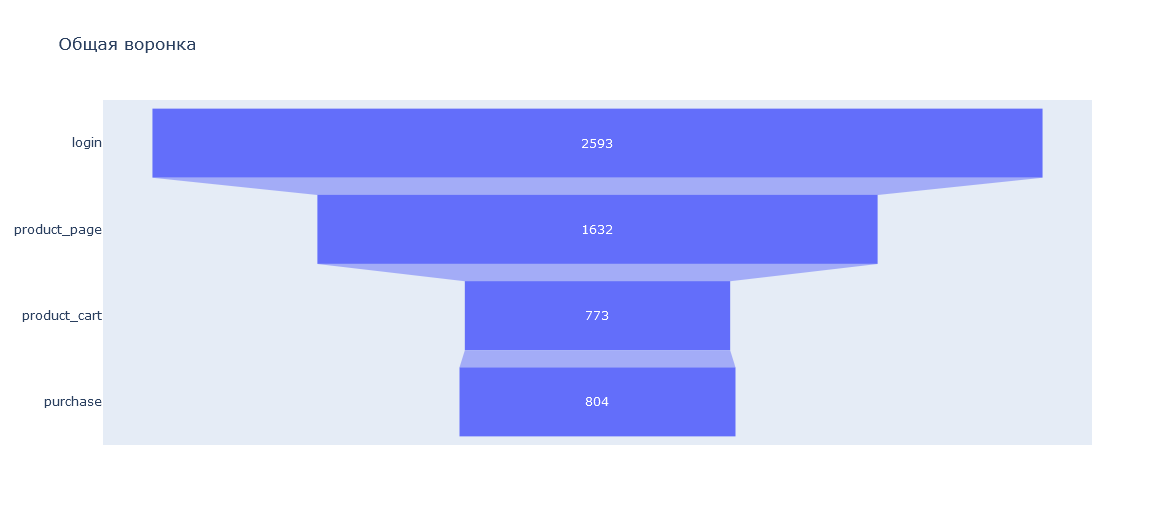

In [67]:
fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text="Общая воронка")))

fig.add_trace(go.Funnel(name='Ff',
    y = total_users['event_name'],
    x = total_users['user_id'],
    ))

Image.open("/content/newplot(10).png").show();

На каждом шаге теряется от 30% до 50% пользователей, в итоге до покупки доходит только 16%.

#### Воронка по группам

In [58]:
a = recommender_system_test.query("group == 'A'").groupby('event_name')['user_id'].nunique()\
    .sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'count'})
totala = a.iloc[0]['count']
a['percent'] = round((a['count'] / totala*100),2)

b = recommender_system_test.query("group == 'B'").groupby('event_name')['user_id'].nunique().\
    sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'count'})
totalb = b.iloc[0]['count']
b['percent'] = round((b['count'] / totalb*100),2)

In [59]:
a=a.reindex(new_index)
a

,event_name,count,percent
0,login,1939,100.00
1,product_page,1265,65.24
3,product_cart,589,30.38
2,purchase,613,31.61


In [60]:
b=b.reindex(new_index)
b

,event_name,count,percent
0,login,654,100.00
1,product_page,367,56.12
3,product_cart,184,28.13
2,purchase,191,29.20


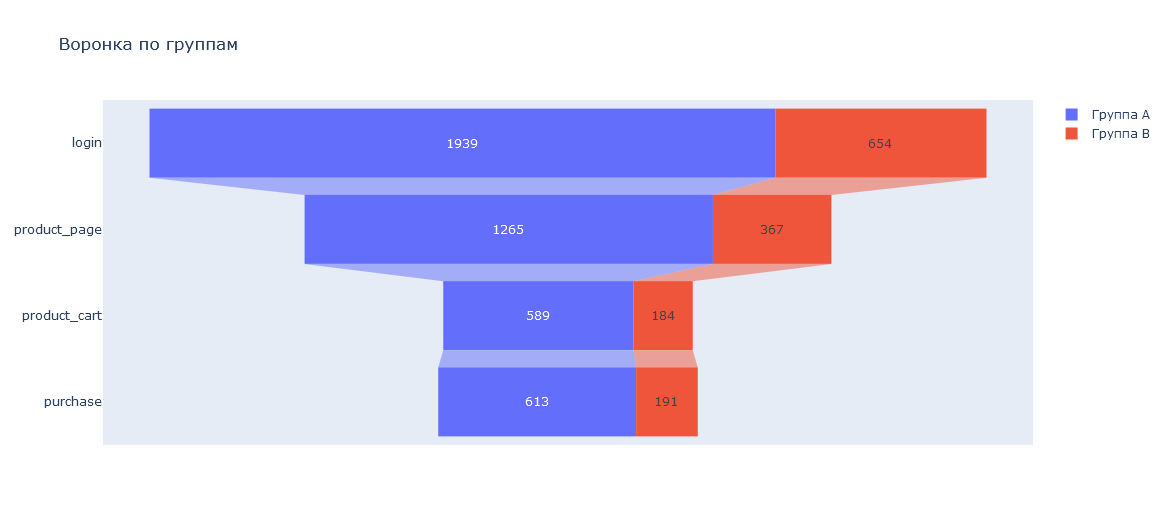

In [68]:
fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text="Воронка по группам")))

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = a['event_name'],
    x = a['count'],
    ))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = b['event_name'],
    x = b['count'],
    ))



Image.open("/content/newplot(11).png").show();

Разницы в группах практически нет, выводы аналогичны выводу к общей воронке.

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Рождественские праздники пересекается с временем проведения теста, но не влияют на него, так как в дату начала праздников всплесков не обнаружено.

Время проведения теста - с 07.12.2020 по 30.07.2020, а не по 04.01.2021, как заявлено;

Время остановки набора новых пользователей: 2020-12-21, соответствует ТЗ

Аудитория теста - 6351, на 5% больше заявленной;

Аудитория: 15% новых пользователей из региона EU, как и заявлено

Пересечения по группам нет, в группе А 2713 участников, в группе В - 2036, распределение неравномерно, 33,7% пользователей участвуют одновременно в двух тестах, они были удалены.

На пользователей группы А приходится на 1.5 действия больше

Особенности воронки: конверсия в группах идентичная, на каждом шагу отваливается от 30% до 50% учатников, до оплаты доходит лишь менее 15%. Такой шаг, как просмотр корзины, необязателен для покупки, поэтому удалён из воронки

## Проведите оценку результатов A/B-тестирования:

### Результаты A/B-тестирования

In [62]:
display(a)
print('-------------------------------')
display(b)

,event_name,count,percent
0,login,1939,100.00
1,product_page,1265,65.24
3,product_cart,589,30.38
2,purchase,613,31.61


-------------------------------


,event_name,count,percent
0,login,654,100.00
1,product_page,367,56.12
3,product_cart,184,28.13
2,purchase,191,29.20


Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Полученный эффект: улучшений в метрике нет, разница в каждом шаге между группами составляет от -9 до -2%.

### Проверьте статистическую разницу долей z-критерием
Н0 - между долями нет статистической разницы

Н1 - между долями есть статистическая разница

#### Первый шаг

In [63]:
alpha = .05/2 # критический уровень статистической значимости с поправкой Бонферрони

successes = np.array([a.iloc[1]['count'], b.iloc[1]['count']])
trials = np.array([a.iloc[0]['count'], b.iloc[0]['count']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

print(successes[0] , successes[1] , trials[0] , trials[1])

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

1265 367 1939 654
p-значение:  2.9463911899618722e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Второй шаг

In [64]:
successes = np.array([a.iloc[2]['count'], b.iloc[2]['count']])
trials = np.array([a.iloc[0]['count'], b.iloc[0]['count']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

print(successes[0] , successes[1] , trials[0] , trials[1])

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

589 184 1939 654
p-значение:  0.2784249853300258
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Третий шаг

In [65]:
successes = np.array([a.iloc[3]['count'], b.iloc[3]['count']])
trials = np.array([a.iloc[0]['count'], b.iloc[0]['count']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

print(successes[0] , successes[1] , trials[0] , trials[1])

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

613 191 1939 654
p-значение:  0.24933015751802245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


## Результаты

Выводы:

По сравнению с ТЗ:

Время проведения теста - с 07.12.2020 по 30.07.2020, а не по 04.01.2021, как заявлено;
Аудитория теста - 6351, на 5% больше заявленной;
Время остановки набора новых пользователей: 2020-12-21, соответствует ТЗ
Аудитория: 15% новых пользователей из региона EU, как и заявлено

Время проведения теста совпадает с двумя событиями: Лотерея в регионе CIS, что не влияет на тест, и Рождественские праздники, что касается Европы, пересекается с тестом и может повлиять на результаты, но не повлияло, так как в начале праздником никаких всплесков действий не наблюдалось

Также 10% пользователей участвовали в одновременно и в другом тесте, проходившем параллельно. Эти пользователи удалены.

На пользователей группы А приходится на 1.5 действия больше, сами же группы неравномерн - 1939 участников в группе А и 654 в группе В, соотношение - 3 к 1.

На каждом шаге в воронке теряется от 30% до 50% пользователей, в итоге до покупки доходит только  менее 14%. Важно отметить, что просмотров корзины меньше, чем покупок (финального шага), делаем предположение, что просмотр корзины необязательный шаг и для анализа не важен.

В обеих группах наблюдается малое количество действий до 14 декабря, в котором у группы А происходит всплеск, вызванный огромным количеством новых регистраций.

Ожидаемый эффект тестирования: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Полученный эффект: улучшений в метрике нет, разница в каждом шаге между группами составляет от -9 до -2%

Исходя из вышеизложенного, новая платёжная воронка снижает конверсии, вместо ожидаемого повышения. Рекомендуется увеличить количество участников в группе В и продолжить тест.